In [2]:
<h1 align="center">Check Questions</h1> 

SyntaxError: invalid syntax (<ipython-input-2-7d7b220be7be>, line 1)

Ответе на вопросы своими словами, если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1**: В каком пространстве градиентный бустинг совершает градиентный спуск? Какова размерность этого пространства?

Градиентный бустинг совершает градиентный спуск в пространстве алгоритмов. Размерность этого пространства равна размерности пространства признаков.

**Вопрос 2**: Почему бустинг над глубокими деревьями это плохая идея?

Есть риск переобучения. Т.е. у алгоритма есть возможность запомнить ответы на тренировачной выборке.

**Вопрос 3**: Что предсказывает каждое дерево (что является признаками а что целевой переменной?)

Целевой переменной явлется алгоритмы, а признаками - наши входные признаки

<h1 align="center">Binary Boosting Implementation</h1> 

Давайте вспомним бустинг

#### Градиентный спуск

Самый простой метод минимизации функции, для оптимизации в каждый момент времени двигаемся по антиградиенту функции с каким-то шагом. 

$$w_{n+1} = w_n - s \cdot \frac{\partial f}{\partial w}$$

#### Градиентный бустинг

Теперь давайте представим, что на каждом шаге мы оптимизируем не параметры алгоритма $w$, а ответы нашего алгоритма $\hat{y}$.

**Обучение**: На каждом шаге, давайте предсказывать градиент на каждом объекте и "двигать" ответ в сторону улучшения (антиградиента).

**Алгоритм**:
- Первый алгоритм отвечает константу 
- Добавляем базовые алгоритмы $b_i$, $i = 1, .., N$:
    - $\hat{y} = \sum_{j=0}^{i-1} a_j b_j(x)$
    - Вычисляем градиент функции потерь ПО ОТВЕТАМ модели $g_{i-1} = \frac{\partial L(\hat{y},~~y)}{\partial \hat{y}}$ на каждом объекте  
    - Обучаем $b_i$ предсказывать текущий $g_{i-1}$ (Тут дерево не глубокое регрессионное дерево)
    - Дополняем композицию $\sum_{j=0}^{i-1} a_j b_j (x) + lr * b_i(x)$
    
    
#### Нужно реализовать двух классовый бустинг с логистической функцией потерь.     

**Функция потерь**:
Я вот думаю, что всем интересно какую-же функцию потерь выбрать $\mathcal{L}(\hat{y},y)=\log\left( 1 + e^{-\hat{y}y} \right)$

тут важный момент есть, даже не один
- $\hat{y}$ -- это ответ композиции, тоесть сумма ответов всех предыдущих деревьев
- Это скалярная функция и производная халява, но вот тут мы вам посчитали $$\frac{\partial \mathcal{L}}{\partial \hat{y}} = \frac{1}{1 + e^{-y\hat{y}}} \cdot (-ye^{-y\hat{y}})=-y\frac{1}{1 + e^{y\hat{y}}}$$

In [1]:
%pylab inline

import warnings
import numpy as np
import pandas as pd
from copy import deepcopy
from utils import plot_surface
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.ensemble import GradientBoostingClassifier
from scipy import special

warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


/home/nikita/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
class BinaryBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators, lr=0.1):
        self.lr = lr   
        self.n_estimators = n_estimators
        self.estimators_ = []
    
    def loss_grad(self, original_y, pred_y):
        # Функция должна вернуть вектор длины = len(pred_y)
        # В каждом элементе вектора должно быть значение градиента dL(pred_y, original_y) / d pred_y[i]
        grad = -special.expit(original_y * pred_y) * original_y
        return grad # Градиент на каждом объекте
        
    def fit(self, X, original_y):
        # Храните базовые алгоритмы тут
        self.estimators_ = [] 
        
        for i in range(self.n_estimators):
            grad = self.loss_grad(original_y, self._predict(X))
            # Настройте базовый алгоритм на градиент, это классификация или регрессия?
            estimator = DecisionTreeRegressor(max_depth=5, min_samples_leaf=3)
            estimator.fit(X, self._predict(X) - self.lr * grad)
            self.estimators_.append(estimator)

        return self

    def _predict(self, X):
        # Эта штука как раз должна вернуть сумму ответов всех алгоритмов 
        # Не забудьте про ленинг рейт
        y_pred = np.zeros(X.shape[0])
        #print len(self.estimators_)
        #print self.estimators_
        for j in range(len(self.estimators_)):
            y_pred += self.estimators_[j].predict(X)
        return y_pred
    
    def predict(self, X):
        # А тут на выходе должны быть классы, подумайте как это сделать
        y_pred = np.sign(self._predict(X))
        return y_pred

<h1 align="center">Simple test</h1> 

In [20]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)
y = 2*(y-0.5)

CPU times: user 532 ms, sys: 0 ns, total: 532 ms
Wall time: 584 ms


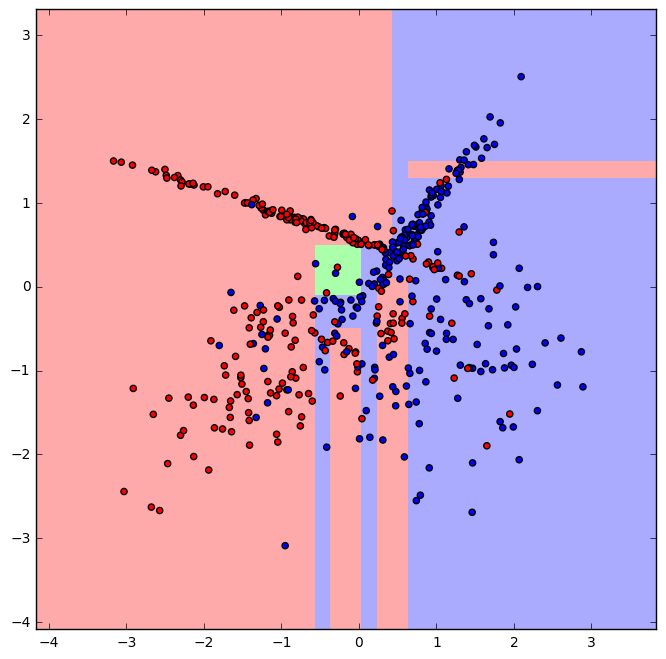

In [21]:
%%time
boost = BinaryBoostingClassifier(n_estimators=100)
clf = boost.fit(X, y)
plot_surface(X, y, clf)

CPU times: user 124 ms, sys: 0 ns, total: 124 ms
Wall time: 173 ms


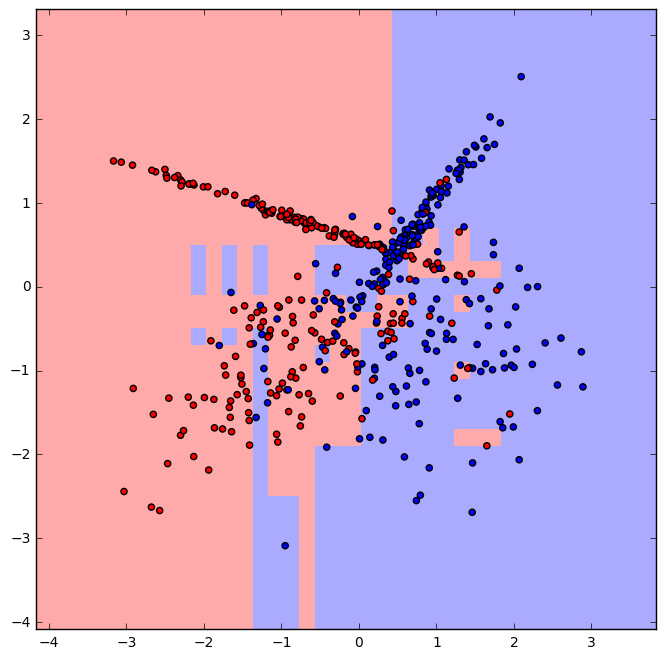

In [22]:
%%time
boost = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=3, max_depth=5)
clf = boost.fit(X, y)
plot_surface(X, y, clf)

<h1 align="center">Adult test</h1> 

#### Скачайте https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

In [23]:
adult = pd.read_csv(
    './adult.data', 
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"], 
    header=None, na_values="?")
adult = pd.get_dummies(adult)
adult["Target"] = adult["Target_ >50K"]

In [24]:
X, y = adult[adult.columns[:-3]].values, adult[adult.columns[-1]].values
y = 2*(y-0.5)

In [25]:
tree = GradientBoostingClassifier()

In [26]:
%%time
cross_val_score(tree, X, y)

CPU times: user 35.5 s, sys: 36 ms, total: 35.5 s
Wall time: 36.6 s


array([ 0.86226276,  0.86493459,  0.86998986])

In [27]:
my_tree = BinaryBoostingClassifier(n_estimators=100)

In [28]:
%%time
cross_val_score(my_tree, X, y)

CPU times: user 2min 34s, sys: 16 ms, total: 2min 34s
Wall time: 2min 34s


array([ 0.8465082 ,  0.84531048,  0.85119322])

<h1 align="center">Сдача ДЗ</h1> 

Заполните форму https://goo.gl/forms/sPE6gpRDNTOXQai12 
    - Качество вашего алгоритма на adult, один знак после запятой, без округления (0.86 -> 0.8 и тд) точность
    - BinaryBoostingClassifier.loss_grad ([-1, 1, 1], [-1, 1, -1]).sum()

In [29]:
estimator = BinaryBoostingClassifier(n_estimators=100)
loss =  estimator.loss_grad (np.array([-1, 1, 1]), np.array([-1, 1, -1]))
print loss.sum()

-0.26894142137
